1. Process data into pickles with skip 40
2. Load this in to df dataloader
3. Train simple MLP map o -> a, observe it being okay
4. Get play subsequences, do goal conditioned BC, not just BC
5. LFP planner/encoder
6. Label a couple subsequences w/ language, and map that to the z space!

# Data Creation

In [1]:
# # # Clean old data
# import glob
# import os
# demo_dir = os.getcwd() + '/' + "kitchen_demos_multitask/"
# old = glob.glob(demo_dir + "/**/*.pkl", recursive=True)
# movies = glob.glob(demo_dir + "/**/*.mp4", recursive=True)
# for i in old + movies:
#     print(i)
#     os.remove(i)

/home/sholto/Desktop/AI/learning_from_play/kitchen_demos_multitask/postcorl_kettle_topknob_bottomknob_hinge/kitchen_playdata_2019_07_11_18_06_46_playback.mp4
/home/sholto/Desktop/AI/learning_from_play/kitchen_demos_multitask/friday_microwave_bottomknob_switch_slide/kitchen_playdata_2019_06_28_12_39_06_playback.mp4
/home/sholto/Desktop/AI/learning_from_play/kitchen_demos_multitask/friday_microwave_kettle_bottomknob_slide/kitchen_playdata_2019_06_28_12_02_31_playback.mp4


In [3]:
# If Colab
COLAB = False
from google.colab import drive
drive.mount('/content/drive/')

if COLAB:
    class config(object):
        pass

    config = config()
    config.PYBULLET_PLAY = 'play_data/'
    config.DEVICE = 'TPU'

    %cd drive/My\ Drive

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Dataset

In [1]:
import glob
import data
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
import config
import random

dataset_path  = config.PYBULLET_PLAY #config.RPL_PATH
keys = ['obs', 'acts', 'achieved_goals', 'joint_poses', 'target_poses']
physical_devices = tf.config.list_physical_devices(config.DEVICE)
if config.DEVICE is 'GPU':
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
# 
RELATIVE_JOINTS = True # use relative joiints instead of absolute angles

In [3]:
#dataset, cnt = data.create_single_dataset(dataset_path)


dataset, cnt = data.load_data(dataset_path, keys)

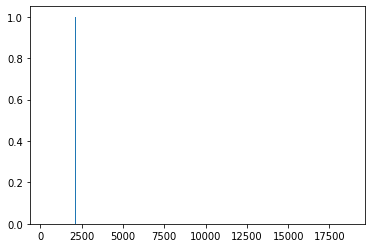

In [4]:
# Histogram of sequence lengths
plt.bar(cnt.keys(), cnt.values(), width=1)
plt.show()

In [5]:
total_frames = sum([x[0]*x[1] for x in cnt.items()])
print(f"We have {total_frames} frames of data, which is {total_frames/20/60} minutes.")

We have 115041 frames of data, which is 95.8675 minutes.


In [128]:
class PyBulletRobotSeqDataset():
    def __init__(self, dataset, batch_size=64, seq_len=80, overlap=1.0, 
                 prefetch_size=None, train_test_split=0.8, seed=42, relative_joints=False):
        self.N_TRAJS = len(dataset)

        # Split into train and validation datasets
        # List of trajectory dicts
        if train_test_split == 'last': # just use the last set of demos as validation
            self._train_data = dataset[:-1] # raw data - private
            self._valid_data = dataset[-1:]
        else:
            self._train_data = dataset[:int(self.N_TRAJS*train_test_split)] # raw data - private
            self._valid_data = dataset[int(self.N_TRAJS*train_test_split):]
        self.train_data = []
        self.valid_data = []
        self.BATCH_SIZE = batch_size
        self.PREFETCH_SIZE = prefetch_size
        self.OVERLAP = overlap
        self.relative_joints = relative_joints

        self.MAX_SEQ_LEN = seq_len ## 40 for example
        self.MIN_SEQ_LEN = seq_len//2 # so like 20
        self.OBS_DIM = dataset[0]['obs'].shape[-1]
        if self.relative_joints:
            self.ACT_DIM = dataset[0]['target_poses'].shape[-1] + 1 # +1 for the gripper
        else:
            self.ACT_DIM = dataset[0]['acts'].shape[-1]
            
        self.GOAL_DIM = dataset[0]['achieved_goals'].shape[-1]

        self.random_obj = random.Random(seed)

    def create_goal(self, trajectory, ti, tf):
        return np.tile(trajectory['achieved_goals'][tf, :], (tf-ti,1))

    def traj_to_subtrajs(self, trajectory, idx):
        """
        Converts a T-length trajectory into M subtrajectories of length SEQ_LEN, pads time dim to SEQ_LEN
        """
        T = len(trajectory['obs'])
        subtrajs = []
        window_size = max(int(self.MAX_SEQ_LEN*self.OVERLAP),1)
        for ti in range(0,T,window_size):
            SEQ_LEN = np.random.randint(self.MIN_SEQ_LEN, self.MAX_SEQ_LEN) # random sequence lengths
            tf = ti + SEQ_LEN
            if T-1 < tf:
                break #trajectory would be cut off by the end of the data 
                
            pad_len = self.MAX_SEQ_LEN-(tf-ti)
            time_padding = ((0,pad_len),(0,0))
            #print(trajectory['obs'][ti:tf,:].shape, np.pad(trajectory['obs'][ti:tf,:], time_padding).shape)
            #print(np.pad(self.create_goal(trajectory, ti, tf), time_padding).shape)
            #print(np.pad(np.ones(tf-ti), time_padding[0]).shape)
            #print(np.pad(np.arange(ti, tf, 1), time_padding[0]).shape)
            
            if self.relative_joints:
                rel = trajectory['target_poses'][ti:tf] - trajectory['joint_poses'][ti:tf, :7]
                gripper = np.expand_dims(trajectory['acts'][ti:tf, -1], -1)
                action = np.pad(np.concatenate([rel, gripper], -1), time_padding)
            else:
                action = np.pad(trajectory['acts'][ti:tf], time_padding)
                
            
            subtraj_dict = {
                            'obs':np.pad(trajectory['obs'][ti:tf,:], time_padding)
                            , 'acts':action
                            , 'goals':np.pad(self.create_goal(trajectory, ti, tf), time_padding)
                            , 'loss_mask': np.pad(np.ones(tf-ti), time_padding[0])
                            , 'dataset_path':trajectory['reset_idx'] # which trajectory it is in the datadir
                            , 'tstep_idxs':np.pad(np.arange(ti, tf, 1), time_padding[0])   # which tstep it is in the trajectory
                            }
            subtrajs.append(subtraj_dict)
        return subtrajs

    def convert_dataset(self):
        """ Converts raw dataset to a shuffled subtraj dataset """
        for idx, train_sample in enumerate(self._train_data):
            self.train_data.extend(self.traj_to_subtrajs(train_sample, idx))

        for idx, valid_sample in enumerate(self._valid_data):
            self.valid_data.extend(self.traj_to_subtrajs(valid_sample, idx))

    def create_tf_ds(self, ds_type='train'):
        dataset = self.train_data if ds_type=='train' else self.valid_data
        def gen():
            for d in dataset:
                yield (d['obs'], d['acts'], d['goals'], d['loss_mask'], d['dataset_path'], d['tstep_idxs'])

        with tf.device('/cpu:0'):
            tf_ds =  tf.data.Dataset.from_generator(
                        gen
                        , output_types = (tf.float32, tf.float32, tf.float32, tf.float32, tf.int32, tf.int32)
                        , output_shapes = ((None,self.OBS_DIM), (None,self.ACT_DIM), (None,self.GOAL_DIM), (None), (None), (None)
            ))
            tf_ds = tf_ds.shuffle(len(dataset))
            tf_ds = tf_ds.batch(self.BATCH_SIZE, drop_remainder=True)
            tf_ds = tf_ds.prefetch(self.PREFETCH_SIZE)
        return tf_ds

In [169]:
rsd = PyBulletRobotSeqDataset(dataset, batch_size=32, overlap=0.01, train_test_split='last', relative_joints=RELATIVE_JOINTS)

In [170]:
rsd.convert_dataset()

In [171]:
tf_train_data, tf_valid_data = rsd.create_tf_ds('train'), rsd.create_tf_ds('valid')

In [172]:
t_it = iter(tf_train_data)


In [173]:
o, a, g, m, pth, tsteps = t_it.next()
print(o.shape, a.shape, g.shape, m.shape)

(32, 80, 26) (32, 80, 8) (32, 80, 18) (32, 80)


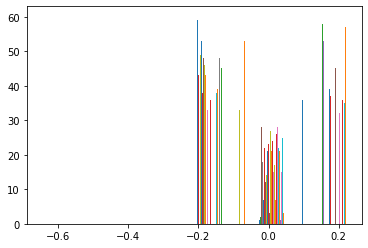

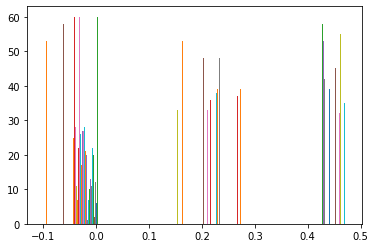

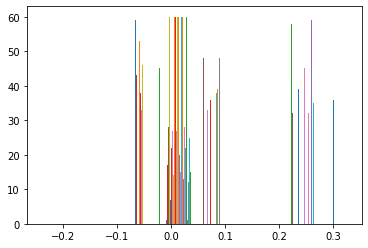

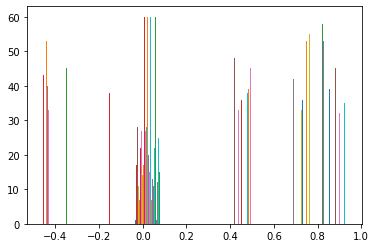

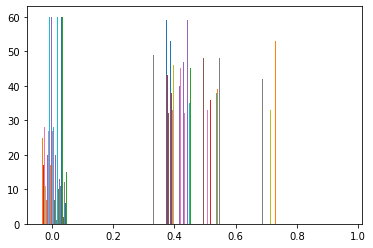

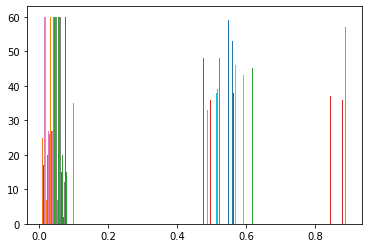

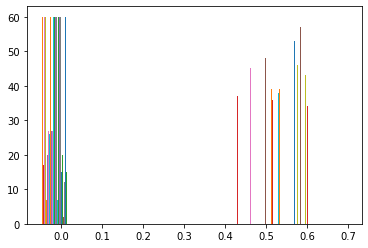

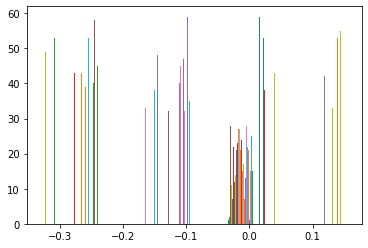

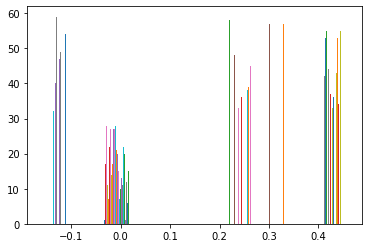

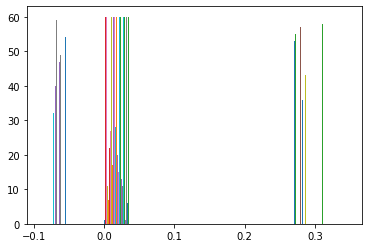

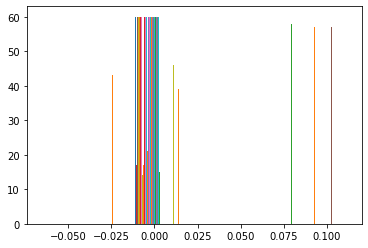

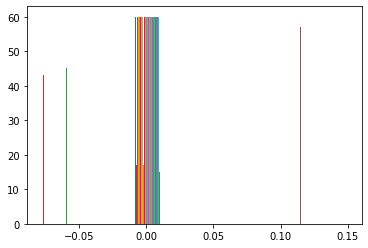

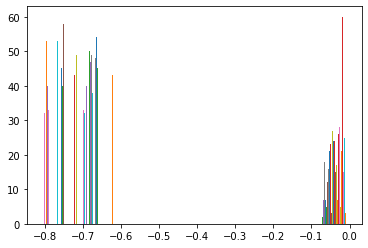

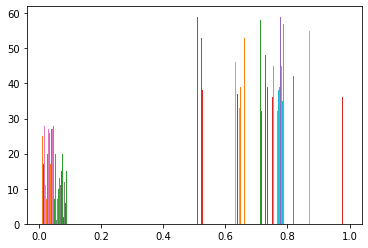

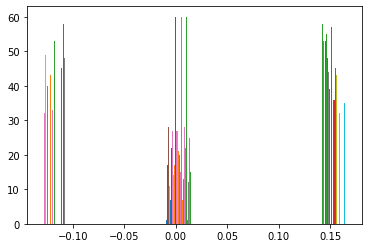

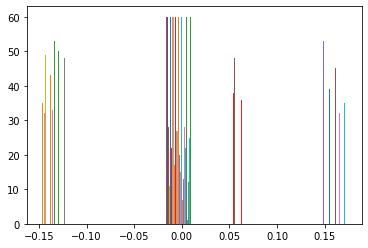

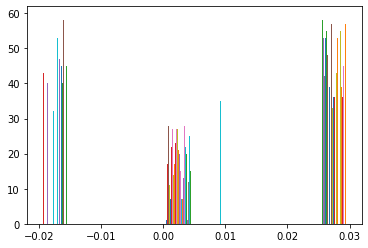

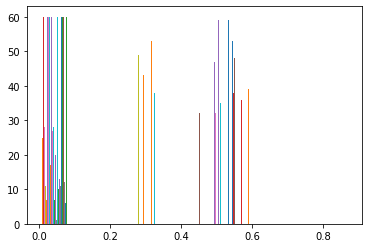

In [106]:
for i in range(0, g.shape[-1]):
    plt.hist( g[:, :, i])
    plt.show()

# Model

In [174]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

## Simple MLP Baseline
Use this to map obs -> act

In [175]:
# a basic determinsitc MLP
class deterministic_MLP(tf.keras.Model):

    def __init__(self, act_dim, layer_size = 256):
        super(deterministic_MLP, self).__init__()
        self.dense1 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(act_dim, activation=None)

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.out(x)
    
    def act(self, inputs):
        return self.call(inputs)
    
# An MLP where the output is a mixture of 3 logistic distributions which we can sample from. 
class stochastic_MLP(tf.keras.Model):

    def __init__(self, act_dim, num_distribs = 3, layer_size = 256):
        super(stochastic_MLP, self).__init__()
        self.num_distribs = num_distribs
        self.act_dim = act_dim
        self.dense1 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.mu = tf.keras.layers.Dense(act_dim*num_distribs, activation=None)
        self.scale = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus")
        self.weightings = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus")

    def call(self, inputs, goal, training=False): # todo confirm works with goal as separate input
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        mu, scale, weightings = self.mu(x), self.scale(x), self.weightings(x)
        mu, scale, weightings = tf.reshape(mu, (-1, self.act_dim, self.num_distribs)), tf.reshape(scale, (-1, self.act_dim, self.num_distribs)), tf.reshape(weightings, (-1, self.act_dim, self.num_distribs))
        dist = tfd.Logistic(loc=mu, scale=scale)
        
        mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
                          probs=weightings),components_distribution=dist)
        
        return mixture
    
    def act(self, inputs):
        return self.call(inputs).sample()
    
    
class LSTM(tf.keras.Model):

    def __init__(self, act_dim, num_distribs = 3, layer_size = 512):
        super(LSTM, self).__init__()
        self.num_distribs = num_distribs
        self.act_dim = act_dim

        self.RNN1 = tf.keras.layers.LSTM(layer_size, return_sequences=True, return_state = True)
        self.RNN2 = tf.keras.layers.LSTM(layer_size, return_sequences=True, return_state = True)
        self.mu = tf.keras.layers.Dense(act_dim*num_distribs, activation=None)
        self.scale = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus")
        self.weightings = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus")

    def call(self, inputs, goal, training=False, past_state = None):
        B = inputs.shape[0]
        inputs = tf.concat([inputs, goal], -1)
        state_out = None
        if len(inputs.shape) == 3:
            [x, _, _] = self.RNN1(inputs)
            [x, _, _] = self.RNN2(x)
        else:
            x = tf.expand_dims(inputs,1)
            [x, s1l1, s2l1] = self.RNN1(x, initial_state = past_state[0])
            [x, s1l2, s2l2] = self.RNN2(x, initial_state = past_state[1])
            state_out = [[s1l1, s2l1], [s1l2, s2l2]]
            

        mu, scale, weightings = self.mu(x), self.scale(x), self.weightings(x)
        mu, scale, weightings = tf.reshape(mu, (B, -1, self.act_dim, self.num_distribs)), tf.reshape(scale, (B, -1, self.act_dim, self.num_distribs)), tf.reshape(weightings, (B, -1, self.act_dim, self.num_distribs))
        dist = tfd.Logistic(loc=mu, scale=scale)
        
        mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
                          probs=weightings),components_distribution=dist)
        if state_out is None:
            return mixture
        else:
            return mixture, state_out

# Training Loop

In [176]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Progbar

import time

# Whether to use probabilstic MLP or not
PROBS = True
# Whether to use LSTM models, as probabilistic models are better they will all be PROB true
SEQ = True


In [183]:

@tf.function
def step(obs,acts, goals, model, mask=None):
    mu = model(obs)
    loss = tf.reduce_mean(tf.losses.MSE(mu, acts))
    return loss

@tf.function
def probabilistic_step(obs,acts,goals, model, mask=None):
    
    mixture = model(obs,goals)
    # make it the same dimension as the mask if we have one
    
    if mask is not None:
        vals = tf.reduce_mean(mixture.log_prob(acts), -1)
        loss = -tf.reduce_mean(vals * mask)
    else:
        loss = -tf.reduce_mean(mixture.log_prob(acts), -1)
    return loss

@tf.function
def train_step(obs,acts, goals, model, optimizer, mask = None):
    with tf.GradientTape() as tape:
        loss = step(obs,acts, goals, model, mask)
        
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss
        

In [184]:
# Instantiate an optimizer to train the model. Use same LR as LFP paper. 
optimizer = Adam(learning_rate=2e-4)
# Instantiate a loss function.

if PROBS:
    step = probabilistic_step
    if SEQ:
        # get_batch = sample_sequence_batch
        model = LSTM(act_dim = rsd.ACT_DIM)
    else:
        model = stochastic_MLP(act_dim = rsd.ACT_DIM)
        # get_batch = sample_MLP_GCBC_batch
else:
    model = deterministic_MLP(act_dim=rsd.ACT_DIM)
    # get_batch = sample_MLP_GCBC_batch

# Prepare the metrics.
# train_acc_metric = Accuracy()

In [179]:
# Maybe load model 
valid_data_iter = iter(tf_valid_data.repeat(-1))
valid_obs, valid_acts, valid_goals, valid_mask,_,_ = valid_data_iter.next()
#valid_obs, valid_acts, valid_goals, valid_mask = sample_sequence_batch(valid_data)
valid_loss = step(valid_obs, valid_acts, valid_goals, model, valid_mask)
model.load_weights('saved_models/test_play')
valid_loss = step(valid_obs, valid_acts, valid_goals, model, valid_mask)
print(valid_loss)

tf.Tensor(-1.4067942, shape=(), dtype=float32)


In [185]:

steps = []
losses = []
valid_losses = []
valid_steps = []
n_steps = 150000
progbar = Progbar(n_steps, verbose=1, interval=0.5)
data_time = []
train_time = []
best_valid_loss = np.float('inf')

In [198]:

# Repeat datasets indefinitely
valid_data_iter = iter(tf_valid_data.repeat(-1))
#train_data_iter = iter(tf_train_data.repeat(-1))

# TODO RAY async trajectories in background so we can watch it's learning progress.
# We want to reshuffle the datset each time

train_data_iter = iter(rsd.create_tf_ds('train'))

t0  = time.time()
for t in range(len(steps),n_steps):
    t1= time.time()
    try:
        train_obs,train_acts,train_goals, train_mask, _,_  = train_data_iter.next()
    except:
        print('Regenning Datset')
        train_data_iter= iter(rsd.create_tf_ds('train'))
        train_obs,train_acts,train_goals, train_mask, _,_  = train_data_iter.next()
        
    #train_obs,train_acts,train_goals, train_mask = sample_sequence_batch(train_data)
    t2 = time.time()
    loss = train_step(train_obs,train_acts,train_goals, model, optimizer, train_mask)
    t3 = time.time()
    data_time.append(t2-t1)
    train_time.append(t3-t2)
    steps.append(t)
    losses.append(loss)
    if t % 100 == 0:
        valid_steps.append(t)
        valid_obs, valid_acts, valid_goals, valid_mask,_,_ = valid_data_iter.next()
        #valid_obs, valid_acts, valid_goals, valid_mask = sample_sequence_batch(valid_data)
        valid_loss = step(valid_obs, valid_acts, valid_goals, model, valid_mask)
        valid_losses.append(valid_loss)
        progbar.add(100, [('Validation Loss', valid_loss)])
        if valid_loss.numpy() <= best_valid_loss:
            model.save_weights('saved_models/test_play')
            best_valid_loss = valid_loss.numpy()
        
        #print(t, valid_loss)
    
    
plt.plot(steps, losses)
plt.plot(valid_steps, valid_losses)
print(f"Total time was {time.time()-t0}")

 32200/150000 [=====>........................] - ETA: 1:21:15 - Validation Loss: -1.7293

KeyboardInterrupt: 

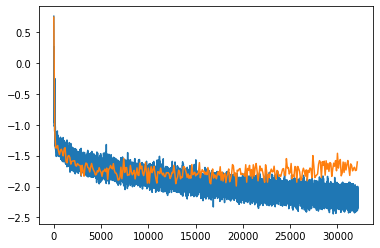

In [199]:
    
plt.plot(steps, losses)
plt.plot(valid_steps, valid_losses)

In [122]:
print(sum(data_time), sum(train_time)) #Tristan pls fix my retarded data input pipieline

1007.2259886264801 18107.928560495377


In [20]:
model.summary()

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                multiple                  4345856   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  24600     
_________________________________________________________________
dense_1 (Dense)              multiple                  24600     
_________________________________________________________________
dense_2 (Dense)              multiple                  24600     
Total params: 12,812,360
Trainable params: 12,812,360
Non-trainable params: 0
_________________________________________________________________


# Perfect, Deterministic Reset and Replay

(64, 40, 22) (64, 40, 8) (64, 40, 14) (64, 40)


In [12]:
import gym
import time
import pandaRL
if RELATIVE_JOINTS:
    env = gym.make('pandaPlayJoints-v0')
else:
    env = gym.make('pandaPlay-v0')
env.render('human')
env.reset()

current_dir=/home/sholto/Desktop/AI/pandaRL/pandaRL/envs


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/home/sholto/Desktop/AI/pandaRL/pandaRL/envs
[1. 1. 1.] (-0.10199041880259217, 0.265184198444029, 0.07576957292436444)
[1. 1. 1.] (0.12261334320353284, 0.17936494592264243, 0.10274436012671904)


{'observation': array([-7.9648115e-02,  2.6829952e-01,  7.4521638e-02, -4.9999979e-01,
         4.9999291e-01,  5.0000691e-01,  5.0000042e-01,  0.0000000e+00,
        -1.0199042e-01,  2.6518419e-01,  7.5769573e-02,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  1.0000000e+00,  1.2261334e-01,
         1.7936495e-01,  1.0274436e-01,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  1.0000000e+00,  4.0123540e-35,  0.0000000e+00,
         1.1067708e-03,  0.0000000e+00], dtype=float32),
 'achieved_goal': array([-1.0199042e-01,  2.6518419e-01,  7.5769573e-02,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  1.0000000e+00,  1.2261334e-01,
         1.7936495e-01,  1.0274436e-01,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  1.0000000e+00,  4.0123540e-35,  0.0000000e+00,
         1.1067708e-03,  0.0000000e+00], dtype=float32),
 'desired_goal': array([-0.05636573,  0.18866186,  0.09306999, -0.09106079,  0.27410164,
         0.06240627], dtype=float32),
 'contr

In [205]:
t_it = iter(tf_train_data)


In [206]:
o, a, g, m, pth, tsteps = t_it.next()
print(o.shape, a.shape, g.shape, m.shape)

(32, 80, 26) (32, 80, 8) (32, 80, 18) (32, 80)


In [192]:
idx = np.random.choice(len(o))
traj_end = len(np.where(m[idx] == 1)[0])-1
#env.panda.reset_goal_pos(ag_to_dg(g[idx, traj_end,:]))
env.p.restoreState(fileName=dataset_path+'states_and_ims/'+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')



In [193]:
env.action_space.high

array([1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.04], dtype=float32)

In [194]:
for i in range(0, traj_end+1):
    #env.p.restoreState(fileName=dataset_path+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,i]))+'.bullet')
    #time.sleep(0.1)
    env.step(a[idx, i, :])

Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds


In [209]:
def test_subsequences(t_it, retries = 3, use_ori = True, replay=False):
    
    
    obs, acts, goals, masks, pth, tsteps = t_it.next()
    idx = np.random.choice(len(obs))
    
    
    start_idx = str(int(tsteps[idx,0]))
    traj_end = len(np.where(masks[idx] == 1)[0])-1
    
    env.p.restoreState(fileName=dataset_path+'states_and_ims/'+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    
    o = tf.expand_dims(obs[idx][0],0)
    
    goal = goals[idx, traj_end,:]
    #env.panda.reset_goal_pos(ag_to_dg(goal))
    goal = tf.expand_dims(goal, 0)
    
    
    if replay:
        retries = 1

        
    for i in range(0,retries):
        past_state = [None, None]
        for i in range(0, traj_end+1):

            distrib, past_state = model(o, goal,  past_state = past_state)
            a = distrib.sample().numpy().squeeze() 
            
            if not use_ori:
                a[3:7] =  np.array(env.panda.default_arm_orn) # because it hasn't ever had to cope with
            if replay:
                a=acts[idx, i, :] # uncomment this to replay play subsequences
            o, r, d, _ = env.step(a)
            o = tf.expand_dims(o['observation'], 0)

In [210]:

dataset = iter(tf_valid_data)
for i in range(0,100):
    test_subsequences(dataset, retries=3)

Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bounds
Outisde bo

KeyboardInterrupt: 

# MLP Evaluation

In [22]:
def ag_to_dg(ag):
    dg = np.concatenate([ag[0:3], ag[7:10]])
    return dg

In [ ]:
# This below is only appropriate for non sequence models, which will aim for shorter timespans. 
n_valid_trajectories = len(valid_data['obs'])
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]

In [ ]:

o = env.reset()
# A few representative points along the trajectory for us to test how it goes from there (before it loses coherence
# over the long trajectory)
ZERO, QUARTER, HALF, THREEQ = 0, len(traj_obs)//4, len(traj_obs)//2, len(traj_obs)*3//4
# Get the init point
init_o = traj_obs[THREEQ][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
# select the goal as the end state of the trajectory 
goal = traj_obs[-1][START_GOAL:END_GOAL]
for i in range(len(traj_acts)):
    o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
    if PROBS:# need to sample from the model if its probabilistic. 
        a = model(o).sample()[0]
    else:
        a = model.predict(o)[0]
    #a = traj_acts[i]
    o, r, d, _ = env.step(a) # the key change
    
    env.render()

# LSTM Evaluation

In [181]:
valid = dataset[int(N_TRAJS*train_partition):]

def test_subsequences():
    
    obs, acts, goals, masks = sample_sequence_batch(valid)
    o = env.reset()
    idx = np.random.choice(len(obs))
    traj_end = len(np.where(masks[idx] == 1)[0])-1

    masks[idx][traj_end]
    start_pos = obs[idx][0][START_OBS:END_OBS].numpy()
    goal = np.expand_dims(obs[idx][traj_end][START_GOAL:END_GOAL],0)
    zero_vel = np.zeros(29)

    env.robot.reset(env, start_pos, zero_vel)
    o = np.squeeze(obs[idx][0])
    env.render()
    past_state = [None, None]
    
    for i in range(0,3):
        for i in range(0, traj_end+1):
            o = tf.expand_dims(o[START_OBS:END_OBS], 0)
            distrib, past_state = model(o, goal,  past_state = past_state)

            a = distrib.sample().numpy().squeeze() 
            #a = acts[idx, i, :] # uncomment this to replay play subsequences
            o, r, d, _ = env.step(a)
            env.render()


In [182]:
for i in range(0,100):
    test_subsequences()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



KeyboardInterrupt: 

In [250]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid)
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_goals, traj_init_o, traj_init_v = [valid[idx][key] for key in valid[idx].keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

    


In [251]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = tf.cast(tf.expand_dims(traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL], 0), tf.float32)
        o = tf.cast(tf.expand_dims(o[START_OBS:END_OBS],0), tf.float32)
        distrib, past_state = model(o,goal, past_state = past_state)
        
        #a = distrib.sample().numpy().squeeze() 
        a = traj_acts[t, :] # uncomment this to replay play subsequences
        o, r, d, _ = env.step(a)
        env.render()

In [249]:
mine = [2,3,2,1,0,1,0,3,3,1,1,3]
fast = [0,2,2,0,1,4,0,2,1,4,3,0]
print(np.mean(mine), np.mean(fast))

1.6666666666666667 1.5833333333333333


In [113]:
tf.concat([o, goal], -1)

<tf.Tensor: shape=(1, 51), dtype=float64, numpy=
array([[ 1.51871719e-01, -1.76243645e+00,  1.84411359e+00,
        -2.48409706e+00,  2.56898912e-01,  7.10735201e-01,
         1.60414358e+00,  4.76829251e-02,  3.34505852e-02,
        -6.93957631e-04,  3.59818540e-04,  1.88936271e-05,
        -9.17078208e-05,  2.70317987e-05, -3.26407870e-05,
         1.01366553e-04,  2.73149432e-05,  7.85193338e-04,
        -1.41369634e-04, -1.76590038e-04, -4.90741034e-03,
        -4.87828186e-03, -7.22135266e-03, -2.69327226e-01,
         3.50088346e-01,  1.61991053e+00,  9.93794669e-01,
         9.67251040e-03, -6.40304943e-03, -7.15231459e-04,
         6.90813167e-05, -4.26762189e-04,  2.56793640e-05,
        -4.81451304e-05, -1.77304657e-05,  4.92727941e-05,
         2.85532431e-06,  3.30886970e-06, -6.22346365e-05,
        -3.66565351e-04,  3.06886044e-04,  7.91593078e-03,
        -5.73506286e-03,  8.24343657e-03, -2.15597678e-01,
         7.40509055e-01,  1.61980319e+00,  1.00316837e+00,
       

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])
#     print()
        
    # Display metrics at the end of each epoch.
#     train_acc = train_acc_metric.result()
#     print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
#     train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
#     for x_batch_val, y_batch_val in val_dataset:
#         test_step(x_batch_val, y_batch_val)

#     val_acc = val_acc_metric.result()
#     val_acc_metric.reset_states()
#     print("Validation acc: %.4f" % (float(val_acc),))    

In [253]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])
#     print()
        
    # Display metrics at the end of each epoch.
#     train_acc = train_acc_metric.result()
#     print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
#     train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
#     for x_batch_val, y_batch_val in val_dataset:
#         test_step(x_batch_val, y_batch_val)

#     val_acc = val_acc_metric.result()
#     val_acc_metric.reset_states()
#     print("Validation acc: %.4f" % (float(val_acc),))    

88.02201747894287 19.151499032974243


In [254]:
model.summary()

Model: "lstm_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               multiple                  1155072   
_________________________________________________________________
lstm_23 (LSTM)               multiple                  2099200   
_________________________________________________________________
dense_21 (Dense)             multiple                  13851     
_________________________________________________________________
dense_22 (Dense)             multiple                  13851     
_________________________________________________________________
dense_23 (Dense)             multiple                  13851     
Total params: 3,295,825
Trainable params: 3,295,825
Non-trainable params: 0
_________________________________________________________________


In [64]:
import gym
import adept_envs

env = gym.make("kitchen_relax-v1")

Reading configurations for Franka
Initializing Franka sim
registering the liscence


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# MLP Evaluation

In [271]:
# This below is only appropriate for non sequence models, which will aim for shorter timespans. 
n_valid_trajectories = len(valid_data['obs'])
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]

In [272]:

o = env.reset()
# A few representative points along the trajectory for us to test how it goes from there (before it loses coherence
# over the long trajectory)
ZERO, QUARTER, HALF, THREEQ = 0, len(traj_obs)//4, len(traj_obs)//2, len(traj_obs)*3//4
# Get the init point
init_o = traj_obs[THREEQ][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
# select the goal as the end state of the trajectory 
goal = traj_obs[-1][START_GOAL:END_GOAL]
for i in range(len(traj_acts)):
    o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
    if PROBS:# need to sample from the model if its probabilistic. 
        a = model(o).sample()[0]
    else:
        a = model.predict(o)[0]
    #a = traj_acts[i]
    o, r, d, _ = env.step(a) # the key change
    
    env.render()

# LSTM Evaluation

In [329]:

def test_subsequences():
    obs, acts, masks = sample_sequence_batch(valid_data)
    o = env.reset()
    idx = np.random.choice(len(obs))
    traj_end = len(np.where(masks[idx] == 1)[0])-1

    masks[idx][traj_end]
    start_pos = obs[idx][0][START_OBS:END_OBS].numpy()
    goal = obs[idx][traj_end][START_GOAL:END_GOAL]
    zero_vel = np.zeros(29)

    env.robot.reset(env, start_pos, zero_vel)
    o = np.squeeze(obs[idx][0])
    env.render()


    past_state = [None, None]

    for i in range(0, traj_end+1):
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()
    

In [ ]:
for i in range(0,100):
    test_subsequences()

In [ ]:
valid_data

In [ ]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid_data)
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

    


In [224]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL]
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()

[{'observations': array([[ 0.10810177, -1.75460301,  1.84669356, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.10794851, -1.7575794 ,  1.84339575, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.09594319, -1.76454973,  1.83375241, ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [-2.45600918, -1.12801851,  1.22960704, ...,  0.        ,
           0.        ,  0.        ],
         [-2.47887897, -1.11504405,  1.23771086, ...,  0.        ,
           0.        ,  0.        ],
         [-2.48408608, -1.12854284,  1.24093161, ...,  0.        ,
           0.        ,  0.        ]]),
  'actions': array([[-0.10909268, -0.05229874, -0.20511103, ...,  0.04268681,
           0.03433496,  0.00273874],
         [-0.19988912, -0.02798985, -0.20723143, ...,  0.07490426,
           0.01891586, -0.04079417],
         [-0.27269046, -0.01334701, -0.13630622, ..., -0.07840108,
           0.01805754, -0.04439726],
         ...,
       

In [223]:
# What about on a full trajectory? Where we give it the intermediate goals?
n_valid_trajectories = len(valid_data)
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]
o = env.reset()
traj_len = len(traj_obs)
intervals = np.array([0, traj_len//4, traj_len//2, traj_len*3//4, traj_len])
init_o = traj_obs[0][START_OBS:END_OBS]# traj_init_o
# reset to our desired init, but with 0 velocity - fine for now. 
env.robot.reset(env, init_o, traj_init_v)
env.render()

    


TypeError: list indices must be integers or slices, not str

In [354]:
past_state = [None, None]
for t in range(traj_len):
        goal_idx = np.where(t < intervals)[0][0] # which part of the task we are up to
        goal = traj_obs[intervals[goal_idx]-1][START_GOAL:END_GOAL]
        o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
        distrib, past_state = model(o, past_state = past_state)
        #a = acts[idx, i, :] # uncomment this to replay play subsequences
        a = distrib.sample().numpy().squeeze() 
        o, r, d, _ = env.step(a)
        env.render()

In [285]:
goal

array([ 1.26637224e-04, -3.02954932e-04, -6.29944632e-06,  2.72272731e-06,
        4.62284669e-05, -4.81784472e-05,  5.64736323e-05,  1.63806061e-05,
       -6.99730864e-01, -4.96205707e-02, -1.97302880e-04,  9.61040826e-03,
        7.20619393e-03,  4.98431317e-04, -2.09994927e-01,  7.28410795e-01,
        1.61963881e+00,  9.98537683e-01,  2.24488211e-03, -3.32025671e-03,
        5.11605555e-02])

2

In [239]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [74]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])
#     print()
        
    # Display metrics at the end of each epoch.
#     train_acc = train_acc_metric.result()
#     print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
#     train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
#     for x_batch_val, y_batch_val in val_dataset:
#         test_step(x_batch_val, y_batch_val)

#     val_acc = val_acc_metric.result()
#     val_acc_metric.reset_states()
#     print("Validation acc: %.4f" % (float(val_acc),))    


Epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



  1/565 [..............................] - ETA: 2:46 - Loss: 0.2236WARNING:tensorflow:5 out of the last 5 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


  7/565 [..............................] - ETA: 1:06 - Loss: 0.2273WARNING:tensorflow:8 out of the last 8 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 12/565 [..............................] - ETA: 1:01 - Loss: 0.2245WARNING:tensorflow:11 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 19/565 [>.............................] - ETA: 55s - Loss: 0.2090 WARNING:tensorflow:9 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 28/565 [>.............................] - ETA: 48s - Loss: 0.1998WARNING:tensorflow:8 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 34/565 [>.............................] - ETA: 47s - Loss: 0.1960WARNING:tensorflow:9 out of the last 12 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 41/565 [=>............................] - ETA: 45s - Loss: 0.1879WARNING:tensorflow:9 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 50/565 [=>............................] - ETA: 42s - Loss: 0.1790WARNING:tensorflow:7 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 58/565 [==>...........................] - ETA: 40s - Loss: 0.1715WARNING:tensorflow:9 out of the last 14 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 66/565 [==>...........................] - ETA: 39s - Loss: 0.1668WARNING:tensorflow:9 out of the last 13 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 77/565 [===>..........................] - ETA: 36s - Loss: 0.1622WARNING:tensorflow:6 out of the last 12 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 87/565 [===>..........................] - ETA: 34s - Loss: 0.1583WARNING:tensorflow:7 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 94/565 [===>..........................] - ETA: 34s - Loss: 0.1555WARNING:tensorflow:9 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


131/565 [=====>........................] - ETA: 24s - Loss: 0.1471WARNING:tensorflow:5 out of the last 16 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


161/565 [=======>......................] - ETA: 20s - Loss: 0.1430WARNING:tensorflow:5 out of the last 16 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


183/565 [========>.....................] - ETA: 17s - Loss: 0.1403WARNING:tensorflow:5 out of the last 12 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


565/565 [==============================] - 10s 19ms/step - Loss: 0.1199

Epoch 1
565/565 [==============================] - 0s 615us/step - Loss: 0.0969

Epoch 2
565/565 [==============================] - 0s 635us/step - Loss: 0.0876

Epoch 3
565/565 [==============================] - 0s 604us/step - Loss: 0.0812

Epoch 4
565/565 [==============================] - 0s 616us/step - Loss: 0.0763

Epoch 5
565/565 [==============================] - 0s 634us/step - Loss: 0.0722

Epoch 6
565/565 [==============================] - 0s 620us/step - Loss: 0.0688

Epoch 7
565/565 [==============================] - 0s 615us/step - Loss: 0.0659

Epoch 8
565/565 [==============================] - 0s 646us/step - Loss: 0.0631

Epoch 9
565/565 [==============================] - 0s 676us/step - Loss: 0.0607

Epoch 10
565/565 [==============================] - 0s 641us/step - Loss: 0.0586

Epoch 11
565/565 [==============================] - 0s 603us/step - Loss: 0.0568

Epoch 12
565/565 [================